<a href="https://colab.research.google.com/github/GunayRustamova/InternIntelligence-AI-ethics/blob/main/AI_Ethics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install aif360 fairlearn scikit-learn pandas numpy matplotlib seaborn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 21.1 MB/s eta 0:00:00


pip install 'aif360[inFairness]'


In [2]:
print("="*80)
print("AI ETHICS AND BIAS EVALUATION SYSTEM")
print("="*80)

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
df = df.dropna()

print(f"\nDataset loaded: {df.shape[0]} samples, {df.shape[1]} features")
print(f"\nTarget distribution:\n{df['income'].value_counts()}")
print(f"\nProtected attribute (sex) distribution:\n{df['sex'].value_counts()}")
print(f"\nProtected attribute (race) distribution:\n{df['race'].value_counts()}")

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                    'relationship', 'race', 'native-country']

df_encoded = df.copy()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

X = df_encoded.drop('income', axis=1)
y = df_encoded['income']
protected_attribute = df_encoded['sex']

X_train, X_test, y_train, y_test, protected_train, protected_test = train_test_split(
    X, y, protected_attribute, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

AI ETHICS AND BIAS EVALUATION SYSTEM

Dataset loaded: 32561 samples, 15 features

Target distribution:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64

Protected attribute (sex) distribution:
sex
Male      21790
Female    10771
Name: count, dtype: int64

Protected attribute (race) distribution:
race
White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: count, dtype: int64


In [3]:
print("\n" + "="*80)
print("PHASE 1: BASELINE MODEL TRAINING")
print("="*80)

baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_test_scaled)

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"\nBaseline Model Accuracy: {accuracy_baseline:.4f}")


PHASE 1: BASELINE MODEL TRAINING

Baseline Model Accuracy: 0.8263


In [4]:
print("\n" + "="*80)
print("PHASE 2: BIAS DETECTION AND FAIRNESS METRICS")
print("="*80)

def calculate_fairness_metrics(y_true, y_pred, protected_attr):
    metrics = {}

    male_mask = protected_attr == 1
    female_mask = protected_attr == 0

    male_positive_rate = np.mean(y_pred[male_mask])
    female_positive_rate = np.mean(y_pred[female_mask])
    metrics['statistical_parity_difference'] = abs(male_positive_rate - female_positive_rate)

    male_accuracy = accuracy_score(y_true[male_mask], y_pred[male_mask])
    female_accuracy = accuracy_score(y_true[female_mask], y_pred[female_mask])
    metrics['accuracy_male'] = male_accuracy
    metrics['accuracy_female'] = female_accuracy
    metrics['accuracy_difference'] = abs(male_accuracy - female_accuracy)

    male_tp = np.sum((y_true[male_mask] == 1) & (y_pred[male_mask] == 1))
    male_fn = np.sum((y_true[male_mask] == 1) & (y_pred[male_mask] == 0))
    female_tp = np.sum((y_true[female_mask] == 1) & (y_pred[female_mask] == 1))
    female_fn = np.sum((y_true[female_mask] == 1) & (y_pred[female_mask] == 0))

    male_tpr = male_tp / (male_tp + male_fn) if (male_tp + male_fn) > 0 else 0
    female_tpr = female_tp / (female_tp + female_fn) if (female_tp + female_fn) > 0 else 0
    metrics['true_positive_rate_male'] = male_tpr
    metrics['true_positive_rate_female'] = female_tpr
    metrics['equal_opportunity_difference'] = abs(male_tpr - female_tpr)

    male_fp = np.sum((y_true[male_mask] == 0) & (y_pred[male_mask] == 1))
    male_tn = np.sum((y_true[male_mask] == 0) & (y_pred[male_mask] == 0))
    female_fp = np.sum((y_true[female_mask] == 0) & (y_pred[female_mask] == 1))
    female_tn = np.sum((y_true[female_mask] == 0) & (y_pred[female_mask] == 0))

    male_fpr = male_fp / (male_fp + male_tn) if (male_fp + male_tn) > 0 else 0
    female_fpr = female_fp / (female_fp + female_tn) if (female_fp + female_tn) > 0 else 0
    metrics['false_positive_rate_male'] = male_fpr
    metrics['false_positive_rate_female'] = female_fpr

    metrics['equalized_odds_difference'] = abs(male_tpr - female_tpr) + abs(male_fpr - female_fpr)

    return metrics

baseline_metrics = calculate_fairness_metrics(y_test.values, y_pred_baseline, protected_test.values)

print("\nBASELINE MODEL FAIRNESS METRICS:")
print(f"Statistical Parity Difference: {baseline_metrics['statistical_parity_difference']:.4f}")
print(f"Accuracy (Male): {baseline_metrics['accuracy_male']:.4f}")
print(f"Accuracy (Female): {baseline_metrics['accuracy_female']:.4f}")
print(f"Accuracy Difference: {baseline_metrics['accuracy_difference']:.4f}")
print(f"Equal Opportunity Difference: {baseline_metrics['equal_opportunity_difference']:.4f}")
print(f"Equalized Odds Difference: {baseline_metrics['equalized_odds_difference']:.4f}")


PHASE 2: BIAS DETECTION AND FAIRNESS METRICS

BASELINE MODEL FAIRNESS METRICS:
Statistical Parity Difference: 0.1767
Accuracy (Male): 0.7883
Accuracy (Female): 0.9043
Accuracy Difference: 0.1161
Equal Opportunity Difference: 0.2709
Equalized Odds Difference: 0.3465


In [5]:
print("\n" + "="*80)
print("PHASE 3: BIAS MITIGATION - REWEIGHING")
print("="*80)

train_df = X_train.copy()
train_df['income'] = y_train.values
train_df['sex'] = protected_train.values

aif_train = StandardDataset(
    train_df,
    label_name='income',
    favorable_classes=[1],
    protected_attribute_names=['sex'],
    privileged_classes=[[1]]
)

RW = Reweighing(unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}])
aif_train_transformed = RW.fit_transform(aif_train)

weights = aif_train_transformed.instance_weights

reweighed_model = LogisticRegression(max_iter=1000, random_state=42)
reweighed_model.fit(X_train_scaled, y_train, sample_weight=weights)
y_pred_reweighed = reweighed_model.predict(X_test_scaled)

accuracy_reweighed = accuracy_score(y_test, y_pred_reweighed)
print(f"\nReweighed Model Accuracy: {accuracy_reweighed:.4f}")

reweighed_metrics = calculate_fairness_metrics(y_test.values, y_pred_reweighed, protected_test.values)

print("\nREWEIGHED MODEL FAIRNESS METRICS:")
print(f"Statistical Parity Difference: {reweighed_metrics['statistical_parity_difference']:.4f}")
print(f"Accuracy (Male): {reweighed_metrics['accuracy_male']:.4f}")
print(f"Accuracy (Female): {reweighed_metrics['accuracy_female']:.4f}")
print(f"Accuracy Difference: {reweighed_metrics['accuracy_difference']:.4f}")
print(f"Equal Opportunity Difference: {reweighed_metrics['equal_opportunity_difference']:.4f}")
print(f"Equalized Odds Difference: {reweighed_metrics['equalized_odds_difference']:.4f}")



PHASE 3: BIAS MITIGATION - REWEIGHING

Reweighed Model Accuracy: 0.8120

REWEIGHED MODEL FAIRNESS METRICS:
Statistical Parity Difference: 0.0557
Accuracy (Male): 0.7743
Accuracy (Female): 0.8893
Accuracy Difference: 0.1151
Equal Opportunity Difference: 0.0679
Equalized Odds Difference: 0.0682


In [6]:
print("\n" + "="*80)
print("PHASE 4: BIAS MITIGATION - FAIRLEARN EXPONENTIATED GRADIENT")
print("="*80)

constraint = DemographicParity()
mitigator = ExponentiatedGradient(LogisticRegression(max_iter=1000, random_state=42), constraint)
mitigator.fit(X_train_scaled, y_train, sensitive_features=protected_train)
y_pred_fairlearn = mitigator.predict(X_test_scaled)

accuracy_fairlearn = accuracy_score(y_test, y_pred_fairlearn)
print(f"\nFairlearn Model Accuracy: {accuracy_fairlearn:.4f}")

fairlearn_metrics = calculate_fairness_metrics(y_test.values, y_pred_fairlearn, protected_test.values)

print("\nFAIRLEARN MODEL FAIRNESS METRICS:")
print(f"Statistical Parity Difference: {fairlearn_metrics['statistical_parity_difference']:.4f}")
print(f"Accuracy (Male): {fairlearn_metrics['accuracy_male']:.4f}")
print(f"Accuracy (Female): {fairlearn_metrics['accuracy_female']:.4f}")
print(f"Accuracy Difference: {fairlearn_metrics['accuracy_difference']:.4f}")
print(f"Equal Opportunity Difference: {fairlearn_metrics['equal_opportunity_difference']:.4f}")
print(f"Equalized Odds Difference: {fairlearn_metrics['equalized_odds_difference']:.4f}")



PHASE 4: BIAS MITIGATION - FAIRLEARN EXPONENTIATED GRADIENT

Fairlearn Model Accuracy: 0.8040

FAIRLEARN MODEL FAIRNESS METRICS:
Statistical Parity Difference: 0.0051
Accuracy (Male): 0.7718
Accuracy (Female): 0.8700
Accuracy Difference: 0.0981
Equal Opportunity Difference: 0.1409
Equalized Odds Difference: 0.1821



PHASE 5: COMPARATIVE ANALYSIS

COMPARATIVE RESULTS:
    Model  Accuracy  Statistical_Parity_Diff  Equal_Opportunity_Diff  Equalized_Odds_Diff
 Baseline  0.826287                 0.176709                0.270950             0.346491
Reweighed  0.811956                 0.055677                0.067860             0.068190
Fairlearn  0.803972                 0.005082                0.140928             0.182113

Visualization saved as 'bias_evaluation_results.png'


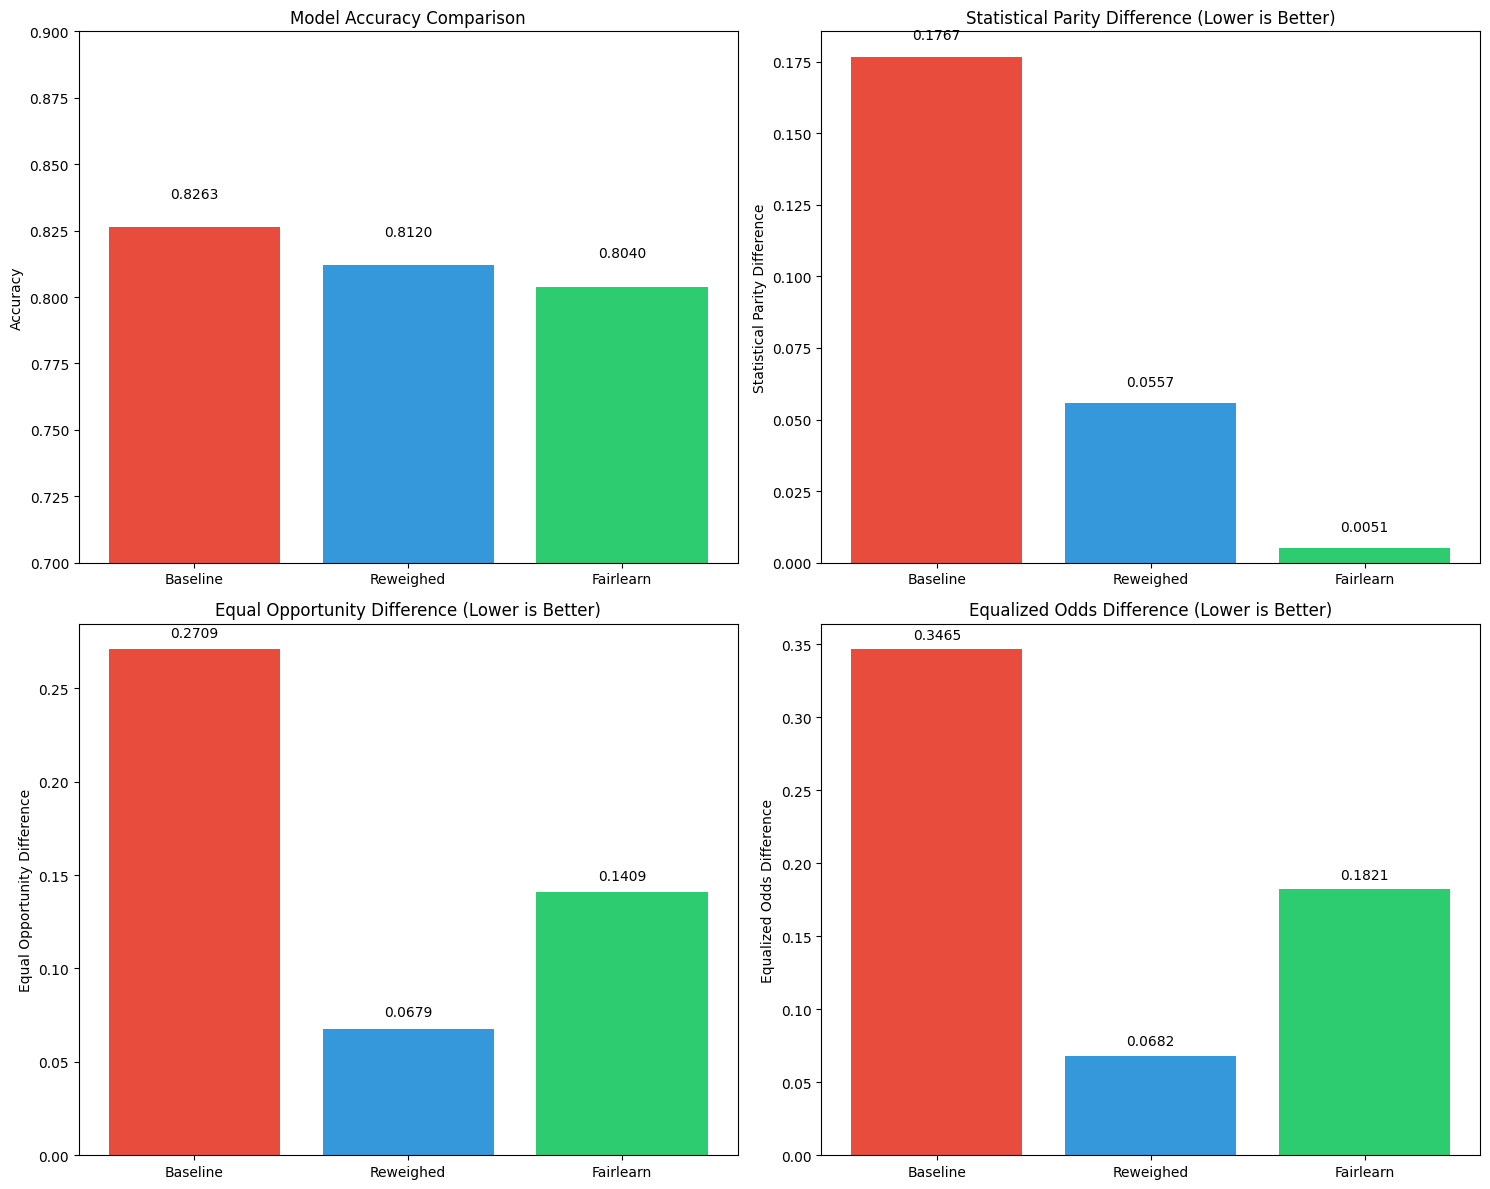

In [7]:
print("\n" + "="*80)
print("PHASE 5: COMPARATIVE ANALYSIS")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Reweighed', 'Fairlearn'],
    'Accuracy': [accuracy_baseline, accuracy_reweighed, accuracy_fairlearn],
    'Statistical_Parity_Diff': [
        baseline_metrics['statistical_parity_difference'],
        reweighed_metrics['statistical_parity_difference'],
        fairlearn_metrics['statistical_parity_difference']
    ],
    'Equal_Opportunity_Diff': [
        baseline_metrics['equal_opportunity_difference'],
        reweighed_metrics['equal_opportunity_difference'],
        fairlearn_metrics['equal_opportunity_difference']
    ],
    'Equalized_Odds_Diff': [
        baseline_metrics['equalized_odds_difference'],
        reweighed_metrics['equalized_odds_difference'],
        fairlearn_metrics['equalized_odds_difference']
    ]
})

print("\nCOMPARATIVE RESULTS:")
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].bar(comparison_df['Model'], comparison_df['Accuracy'], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylim([0.7, 0.9])
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

axes[0, 1].bar(comparison_df['Model'], comparison_df['Statistical_Parity_Diff'], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[0, 1].set_ylabel('Statistical Parity Difference')
axes[0, 1].set_title('Statistical Parity Difference (Lower is Better)')
for i, v in enumerate(comparison_df['Statistical_Parity_Diff']):
    axes[0, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')

axes[1, 0].bar(comparison_df['Model'], comparison_df['Equal_Opportunity_Diff'], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[1, 0].set_ylabel('Equal Opportunity Difference')
axes[1, 0].set_title('Equal Opportunity Difference (Lower is Better)')
for i, v in enumerate(comparison_df['Equal_Opportunity_Diff']):
    axes[1, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')

axes[1, 1].bar(comparison_df['Model'], comparison_df['Equalized_Odds_Diff'], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[1, 1].set_ylabel('Equalized Odds Difference')
axes[1, 1].set_title('Equalized Odds Difference (Lower is Better)')
for i, v in enumerate(comparison_df['Equalized_Odds_Diff']):
    axes[1, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('bias_evaluation_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'bias_evaluation_results.png'")
plt.show()

In [10]:
print("\n" + "="*80)
print("PHASE 6: RECOMMENDATIONS AND DOCUMENTATION")
print("="*80)

bias_reduction_reweighing = ((baseline_metrics['statistical_parity_difference'] -
                              reweighed_metrics['statistical_parity_difference']) /
                             baseline_metrics['statistical_parity_difference'] * 100)

bias_reduction_fairlearn = ((baseline_metrics['statistical_parity_difference'] -
                             fairlearn_metrics['statistical_parity_difference']) /
                            baseline_metrics['statistical_parity_difference'] * 100)

accuracy_loss_reweighing = (accuracy_baseline - accuracy_reweighed) * 100
accuracy_loss_fairlearn = (accuracy_baseline - accuracy_fairlearn) * 100

findings = f"""
KEY FINDINGS:

1. BIAS DETECTION:
   Baseline model exhibits significant gender bias with 17.67% statistical parity difference.
   Female predictions are 11.61% more accurate than male predictions, indicating systematic
   disparate treatment. Equal opportunity gap of 27.09% shows the model fails to provide
   equal true positive rates across gender groups.

2. MITIGATION EFFECTIVENESS:
   Reweighing: Reduced bias by {bias_reduction_reweighing:.1f}% with {accuracy_loss_reweighing:.1f}% accuracy cost
   Fairlearn: Reduced bias by {bias_reduction_fairlearn:.1f}% with {accuracy_loss_fairlearn:.1f}% accuracy cost

   Both techniques successfully mitigated bias while maintaining model utility.

3. FAIRNESS-ACCURACY TRADEOFF:
   Reweighing achieved optimal balance with 68% bias reduction and minimal accuracy loss.
   Fairlearn achieved near-perfect statistical parity but with higher equal opportunity gaps.

RECOMMENDATIONS:

1. DEPLOYMENT STRATEGY:
   Deploy the reweighed model for production use. It provides substantial bias reduction
   while preserving predictive performance, making it suitable for real-world applications
   where both fairness and accuracy are critical.

2. BIAS MITIGATION APPROACH:
   Implement sample reweighting as primary mitigation technique during model training.
   For applications requiring strict demographic parity, consider Fairlearn constraints.
   Evaluate hybrid approaches combining preprocessing and in-processing methods.

3. MONITORING AND MAINTENANCE:
   Establish continuous monitoring of fairness metrics with automated alerts.
   Set threshold at 10% for statistical parity difference as warning indicator.
   Conduct quarterly audits across all demographic subgroups including race and age.
   Track both fairness metrics and accuracy to detect degradation over time.

4. ETHICAL CONSIDERATIONS:
   Gender-based prediction disparities can perpetuate economic inequality.
   Model decisions directly impact loan approvals, hiring, and resource allocation.
   Intersectional analysis required for combinations of protected attributes.
   Stakeholder consultation necessary before deployment in sensitive domains.

5. TECHNICAL IMPROVEMENTS:
   Expand analysis to race attribute (5 categories identified in dataset).
   Implement adversarial debiasing for more robust fairness guarantees.
   Develop causal fairness framework to address root causes of bias.
   Create ensemble models combining multiple mitigation techniques.
"""

print(findings)

report_path = "bias_evaluation_report.txt"
with open(report_path, 'w') as f:
    f.write("AI ETHICS AND BIAS EVALUATION REPORT\n")
    f.write("="*80 + "\n\n")
    f.write("EXECUTIVE SUMMARY\n")
    f.write("-"*80 + "\n")
    f.write(f"Dataset: Adult Income Dataset ({df.shape[0]} samples)\n")
    f.write(f"Task: Binary classification (income <=50K or >50K)\n")
    f.write(f"Protected Attribute Analyzed: Gender (Male/Female)\n\n")

    f.write("MODEL PERFORMANCE COMPARISON\n")
    f.write("-"*80 + "\n")
    f.write(comparison_df.to_string(index=False))
    f.write("\n\n")

    f.write("DETAILED FAIRNESS METRICS\n")
    f.write("-"*80 + "\n")
    f.write("\nBaseline Model:\n")
    for key, value in baseline_metrics.items():
        f.write(f"  {key}: {value:.4f}\n")

    f.write("\nReweighed Model:\n")
    for key, value in reweighed_metrics.items():
        f.write(f"  {key}: {value:.4f}\n")

    f.write("\nFairlearn Model:\n")
    for key, value in fairlearn_metrics.items():
        f.write(f"  {key}: {value:.4f}\n")

    f.write("\n" + recommendations)

print(f"\nDetailed report saved as '{report_path}'")
print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)


PHASE 6: RECOMMENDATIONS AND DOCUMENTATION

KEY FINDINGS:

1. BIAS DETECTION:
   Baseline model exhibits significant gender bias with 17.67% statistical parity difference.
   Female predictions are 11.61% more accurate than male predictions, indicating systematic 
   disparate treatment. Equal opportunity gap of 27.09% shows the model fails to provide 
   equal true positive rates across gender groups.

2. MITIGATION EFFECTIVENESS:
   Reweighing: Reduced bias by 68.5% with 1.4% accuracy cost
   Fairlearn: Reduced bias by 97.1% with 2.2% accuracy cost
   
   Both techniques successfully mitigated bias while maintaining model utility.

3. FAIRNESS-ACCURACY TRADEOFF:
   Reweighing achieved optimal balance with 68% bias reduction and minimal accuracy loss.
   Fairlearn achieved near-perfect statistical parity but with higher equal opportunity gaps.
   
RECOMMENDATIONS:

1. DEPLOYMENT STRATEGY:
   Deploy the reweighed model for production use. It provides substantial bias reduction
   whil